In [1]:
import pandas as pd 
from sklearn.utils import shuffle
import utils as ut 
from sklearn.model_selection import train_test_split


%matplotlib inline 


In [542]:
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier

## sklearn 

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier,  VotingClassifier, GradientBoostingClassifier,  AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# from imbalance 

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt 



In [2]:
df = pd.read_csv('./dataset_31_credit-g.csv')
df = shuffle(df)

df.head(10)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
817,'no checking',6,'critical/other existing credit',radio/tv,1554,'<100','4<=X<7',1,'female div/dep/mar',none,...,car,24,none,rent,2,skilled,1,yes,yes,good
865,'no checking',15,'existing paid',furniture/equipment,2221,'500<=X<1000','1<=X<4',2,'female div/dep/mar',none,...,car,20,none,rent,1,skilled,1,none,yes,good
342,'0<=X<200',18,'existing paid',radio/tv,3213,'500<=X<1000','<1',1,'male mar/wid',none,...,'real estate',25,none,rent,1,skilled,1,none,yes,good
834,'>=200',15,'existing paid',radio/tv,2327,'<100','<1',2,'female div/dep/mar',none,...,'real estate',25,none,own,1,'unskilled resident',1,none,yes,bad
169,'0<=X<200',24,'critical/other existing credit',business,1935,'<100','>=7',4,'male div/sep',none,...,'real estate',31,none,own,2,skilled,1,yes,yes,bad
477,'>=200',24,'existing paid',radio/tv,5152,'<100','4<=X<7',4,'male single',none,...,car,25,bank,own,1,skilled,1,none,yes,good
350,'no checking',9,'existing paid','domestic appliance',1236,'<100','<1',1,'female div/dep/mar',none,...,'real estate',23,none,rent,1,skilled,1,yes,yes,good
309,'0<=X<200',9,'existing paid','new car',276,'<100','1<=X<4',4,'male mar/wid',none,...,'real estate',22,none,rent,1,'unskilled resident',1,none,yes,good
775,'<0',24,'existing paid','new car',1371,'no known savings','1<=X<4',4,'female div/dep/mar',none,...,'real estate',25,none,rent,1,skilled,1,none,yes,bad
5,'no checking',36,'existing paid',education,9055,'no known savings','1<=X<4',2,'male single',none,...,'no known property',35,none,'for free',1,'unskilled resident',2,yes,yes,good


In [ ]:
## plotting data 
ut.plot_df(df)

## First thoughts. 
    - Classification problem 
    - Imbalanced classes - 700 vs 300 
        - can be handlesd with oversampling or undersampling - in the case of oversampling, be careful with K fold cross validation, will 
        overfit 
        - In undersampling, can ensemble i.e. use the 300 + 300(g), another with 300+different 300(g)
        - can cluster the abundant class and use the medians. 
        - Use more complex algos - bagging, boosting, e.g. Xgboost 
        - Ensemble eveything for best performance 

## Step 0: test train split and defining loss function 

In [486]:
df = ut.label_encode(df)
x0 = df.drop(['class'], axis=1)
y0 = df['class']
x_train, x_test, y_train, y_test = train_test_split(x0, y0, test_size=0.20, random_state=42, shuffle=True)

## Oversampling vs k-fold cross validation 

We have to be careful before using 5-fold cross validation, because if we oversample and then perform the 5-fold cross validation then we will get artificially high accuracies. 
The workaround to this : 

- Inside the cross-validation loop, get a sample out and do not use it for anything 
- Oversample the minority class in the remaining data and use it together with majority to create and fit model
- Repeat k times for k-fold cross validation, where n is your number of samples (if doing leave one participant out cross-validation).

# Note: 

The baseline accuracy is 70\% because thats what we'll get if we guess True across the board. Similarly, the cost function for this case is 1.45. 

## Collecting and ensembling models 

In [491]:
names, classifiers, allscores_precision, allscores_cust = doall(x, y)

/Users/avani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/avani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/avani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/avani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/avani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

In [492]:
ap = np.array(allscores_precision).flatten().reshape(9,11)
ac = np.array(allscores_cust).flatten().reshape(9,11)

apm = np.mean(ap, axis=0)
aps = np.std(ap, axis=0)

acm = np.mean(ac, axis=0)
acs = np.std(ac, axis=0)

> It seems that oversampling, either through SMOTE or the simplest way makes the most difference, as expected. I expect SMOTE will generalize better, so let's continue using it. 

In [493]:
for i in range(11): 
    print(names[i],  "\t Precision = %.2f (+/- %.2f), cost = %.2f (+/- %.2f) " % (apm[i], aps[i], acm[i], acs[i]))

Nearest Neighbors 	 Precision = 0.89 (+/- 0.04), cost = 0.49 (+/- 0.13) 
Gaussian Process 	 Precision = 0.74 (+/- 0.07), cost = 1.13 (+/- 0.30) 
Decision Tree 	 Precision = 0.85 (+/- 0.06), cost = 0.65 (+/- 0.22) 
Random Forest 	 Precision = 0.85 (+/- 0.03), cost = 0.65 (+/- 0.08) 
GradientBoosting 	 Precision = 0.85 (+/- 0.04), cost = 0.63 (+/- 0.16) 
Neural Net 	 Precision = 0.77 (+/- 0.07), cost = 1.06 (+/- 0.39) 
AdaBoost 	 Precision = 0.85 (+/- 0.05), cost = 0.62 (+/- 0.19) 
Naive Bayes 	 Precision = 0.81 (+/- 0.04), cost = 0.78 (+/- 0.13) 
QDA 	 Precision = 0.83 (+/- 0.03), cost = 0.71 (+/- 0.12) 
XGB 	 Precision = 0.88 (+/- 0.03), cost = 0.51 (+/- 0.12) 
LogisticRegression 	 Precision = 0.81 (+/- 0.04), cost = 0.79 (+/- 0.15) 


In [494]:
# now lets ensemble them all and see how we do on the test data. 

In [501]:
arr = []
for i in range(11):
    dt= (names[i], classifiers[i])
    arr.append(dt)

In [517]:
eclf = VotingClassifier(estimators=arr,
                         voting='soft', weights=[2,1,2,2,2,1,2,1,2,2,1])

In [518]:
eclf.fit(x_train, y_train)

VotingClassifier(estimators=[('Nearest Neighbors', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')), ('Gaussian Process', GaussianProcessClassifier(copy_X_train=True,
             kernel=1**2 * RBF(..., penalty='l2', random_state=5, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1])

In [522]:
y_pred = eclf.predict(x_test)
precision = precision_score(y_test, y_pred)
loss = cost_loss_func(y_pred=y_pred, y_true=y_test)
print(precision)
print(loss)

0.8181818181818182
0.82


In [537]:
## it seems that xgb classifier is doing the best of all
y_pred = classifiers[9].predict(x_test.values)
precision = precision_score(y_test, y_pred)
loss = cost_loss_func(y_pred=y_pred, y_true=y_test)
print(precision)
print(loss)

0.9259259259259259
0.37


Confusion matrix, without normalization
[[ 41  10]
 [ 24 125]]


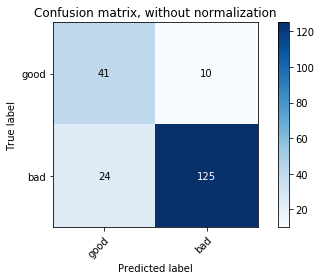

In [541]:
ut.confusion_matrix(y_pred=y_pred,y_true=y_test)
ut.plot_confusion_matrix(classes=['good', 'bad'],normalize=False,title=None,y_pred=y_pred,y_true=y_test)

In [523]:
## To do : hyper-parameter tuning! 